# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 
*hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply 

* Use the Sobol results with N=100

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)

ema_logging.log_to_stderr(ema_logging.INFO)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, 
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/lib/python3.7/site-packages/ema_workbench/analysis/prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)
/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


---

## My work

As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

In [2]:
model = Model('PredPrey', function=pred_prey)

model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                       RealParameter('predator_efficiency', 0.001, 0.004),
                       RealParameter('predator_loss_rate', 0.04, 0.08)]

model.outcomes = [TimeSeriesOutcome('TIME'),
              TimeSeriesOutcome('predators'),
              TimeSeriesOutcome('prey')]

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

In [4]:
from ema_workbench import (MultiprocessingEvaluator, perform_experiments)

with MultiprocessingEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios = 100) # is this appropriate enough?

In [97]:
import statsmodels.formula.api as smf

import pandas as pd

x = experiments.iloc[:,0:4]
print(x.shape)
print(x.columns)

(100, 4)
Index(['predation_rate', 'predator_efficiency', 'predator_loss_rate',
       'prey_birth_rate'],
      dtype='object')


#### For final values of prey

In [98]:
y = outcomes['prey'][:,:,-1]
df = x.join(pd.DataFrame(y)).rename(columns = {0: 'final'})

In [99]:
results = smf.ols(
    'final ~ predation_rate + predator_efficiency + predator_loss_rate + prey_birth_rate',
    data=df).fit()

In [100]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  final   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     16.55
Date:                Sun, 26 May 2019   Prob (F-statistic):           2.55e-10
Time:                        17:40:13   Log-Likelihood:                -413.22
No. Observations:                 100   AIC:                             836.4
Df Residuals:                      95   BIC:                             849.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              48.4260    

#### For mean values of prey

In [101]:
# Mean of prey
prey_mean = pd.Series([row.mean() for row in outcomes['prey']]).rename('mean')
df = df.join(prey_mean)

results = smf.ols(
    'mean ~ predation_rate + predator_efficiency + predator_loss_rate + prey_birth_rate',
    data=df).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     183.0
Date:                Sun, 26 May 2019   Prob (F-statistic):           9.79e-44
Time:                        17:40:13   Log-Likelihood:                -285.43
No. Observations:                 100   AIC:                             580.9
Df Residuals:                      95   BIC:                             593.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              31.5270    

#### For std values of prey

In [102]:
prey_std = pd.Series([row.std() for row in outcomes['prey']]).rename('std')
df = df.join(prey_std)

results = smf.ols(
    'std ~ predation_rate + predator_efficiency + predator_loss_rate + prey_birth_rate',
    data=df).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    std   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     5.103
Date:                Sun, 26 May 2019   Prob (F-statistic):           0.000909
Time:                        17:41:01   Log-Likelihood:                -253.55
No. Observations:                 100   AIC:                             517.1
Df Residuals:                      95   BIC:                             530.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              13.7809    

### Answer
From the above, it seems that `predation_rate` and `predator_efficiency` have the largest effect on all three measures of prey populations by one to two orders of magnitude.

## Sobol

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 
*hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply 



###  N = 50

In [110]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

problem = get_SALib_problem(model.uncertainties)

with MultiprocessingEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=50,
                                               uncertainty_sampling='sobol')
    
## experiments is now 500 rows long, which is 50 * (2*4 + 2)

In [117]:
outcomes['prey'].shape

(500, 1, 1461)

#### Final value

In [142]:
y = outcomes['prey'][:,0,-1]
Si = sobol.analyze(problem, y,
                   calc_second_order=True, print_to_console=False)

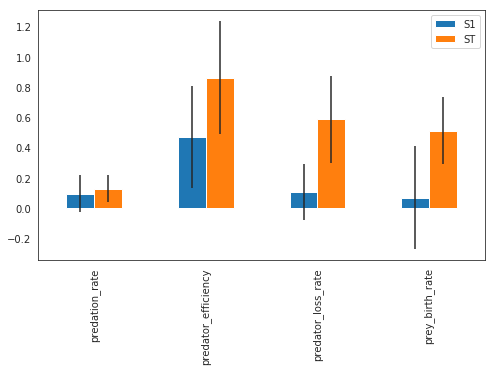

In [139]:
import seaborn as sns

scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

#### Mean

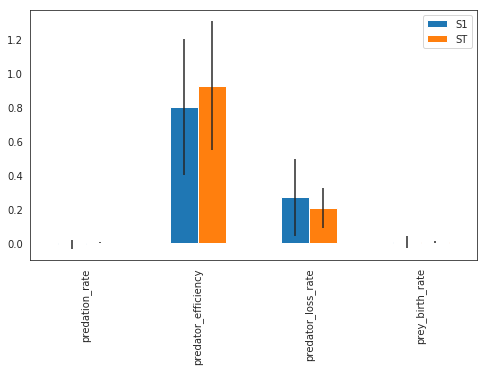

In [145]:
y = np.array([row.mean() for row in outcomes['prey']])
Si = sobol.analyze(problem, y,
                   calc_second_order=True, print_to_console=False)

scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

#### Std

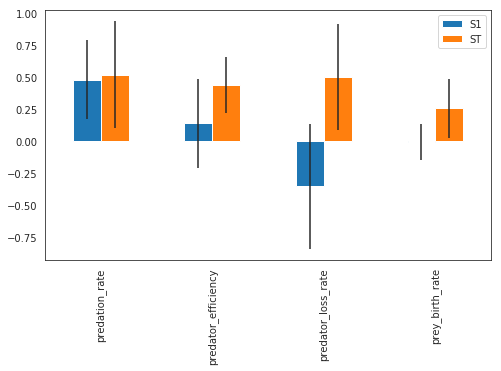

In [146]:
y = np.array([row.std() for row in outcomes['prey']])
Si = sobol.analyze(problem, y,
                   calc_second_order=True, print_to_console=False)

scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

## N = 250

In [147]:
with MultiprocessingEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=250,
                                               uncertainty_sampling='sobol')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 2500 scenarios * 1 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


#### Final value

In [148]:
y = outcomes['prey'][:,0,-1]
Si = sobol.analyze(problem, y,
                   calc_second_order=True, print_to_console=False)

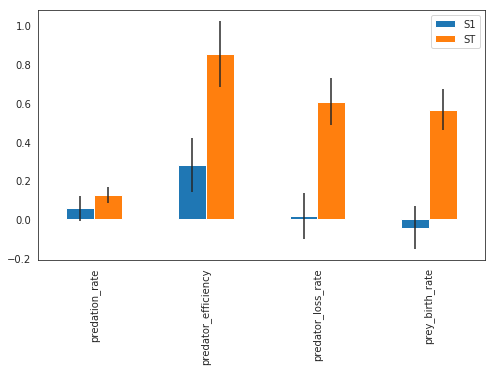

In [149]:
import seaborn as sns

scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

#### Mean

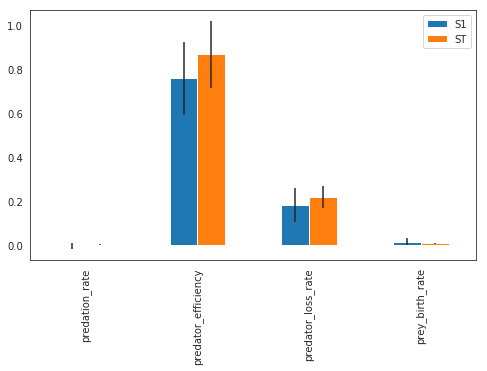

In [150]:
y = np.array([row.mean() for row in outcomes['prey']])
Si = sobol.analyze(problem, y,
                   calc_second_order=True, print_to_console=False)

scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

#### Std

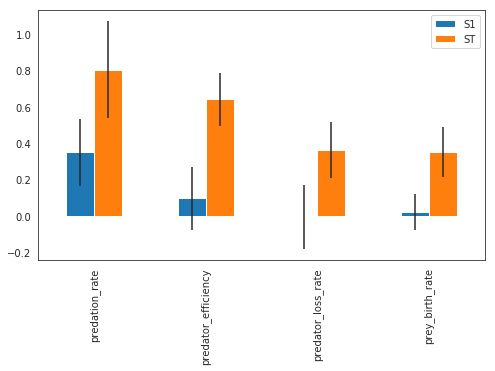

In [151]:
y = np.array([row.std() for row in outcomes['prey']])
Si = sobol.analyze(problem, y,
                   calc_second_order=True, print_to_console=False)

scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

## N = 1000

In [152]:
with MultiprocessingEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000,
                                               uncertainty_sampling='sobol')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


#### Final value

In [153]:
y = outcomes['prey'][:,0,-1]
Si = sobol.analyze(problem, y,
                   calc_second_order=True, print_to_console=False)

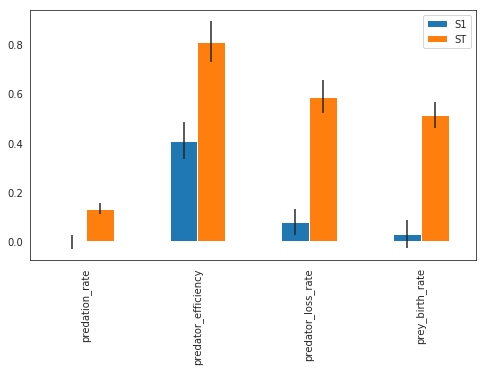

In [154]:
import seaborn as sns

scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

#### Mean

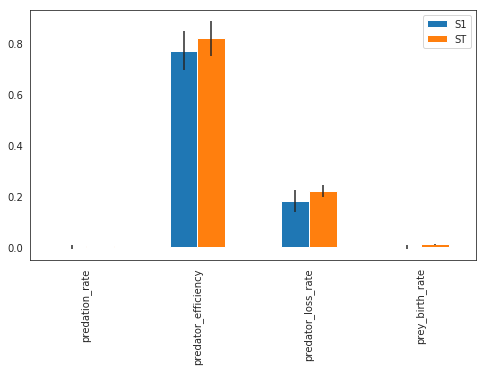

In [155]:
y = np.array([row.mean() for row in outcomes['prey']])
Si = sobol.analyze(problem, y,
                   calc_second_order=True, print_to_console=False)

scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

#### Std

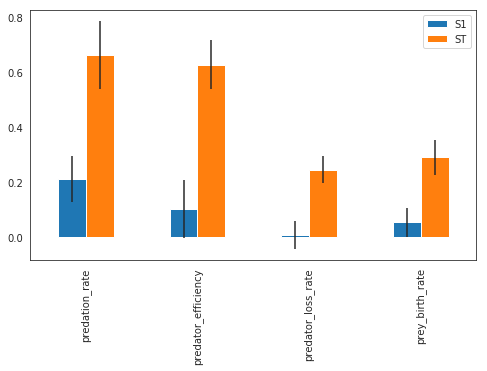

In [156]:
y = np.array([row.std() for row in outcomes['prey']])
Si = sobol.analyze(problem, y,
                   calc_second_order=True, print_to_console=False)

scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

# Extra-Trees

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [174]:
from ema_workbench.analysis.feature_scoring import get_ex_feature_scores

# Final value
x = experiments.iloc[:,:4]
y = outcomes['prey'][:,0,-1]
dfET = get_ex_feature_scores(x, y, nr_trees=100, max_features= 0.6, mode = RuleInductionType.REGRESSION)